# Wooga Data Challenge

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
import matplotlib.lines as mlines
import numpy as np
from scipy.optimize import curve_fit
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


To optimize our spending for user acquisition one of our goals is to acquire users that have a high retention in the game. For this reason, we calculate retention rates for different cohorts. E.g. if we acquire 1000 players on day 0 and 650 players of those play the game on day 3, the day-3-retention would be 65%. If we compute this for every day we get a retention curve that shows us the retention of the cohort over time.

The given data sets contain a sample of users that installed a game in the first week of January. Instead of looking at daily retention here we are interested in weekly retention curves.
We provided you with two csv files:
- ‘user_info.csv’ contains information on the players such as install date, game platform and country. Each row in this file corresponds to a unique player.
- ‘user_logins.csv’ contains information on the activity of a player. Each row in this file corresponds to a different activity date of a given user. There are therefore several rows for a unique user in this file.

Data Dictionary
- user_id: Unique identifier for a player.
- install_date: Date when player installed the game.
- game_platform: Whether the player installed on ios or android.
- campaign:  Identifier of the advertising campaign through which the player installed the game. Value is missing for players that could not be attributed to a campaign.
- activity_date: Date on which the player logged into / played the game.

## Upload and merge data

In [2]:
df1 = pd.read_csv('user_info.csv')
df2 = pd.read_csv('user_logins.csv')

In [3]:
df1.head()

,user_id,install_date,game_platform,country,campaign
0,1111,2018-12-31,android,DE,29.0
1,1119,2018-12-31,android,AT,29.0
2,1121,2018-12-31,android,DE,29.0
3,1141,2018-12-31,android,NL,29.0
4,1144,2018-12-31,android,CH,29.0


In [4]:
df2.head()

,user_id,activity_date
0,1111,2018-12-31
1,1111,2019-01-20
2,1119,2018-12-31
3,1119,2019-01-01
4,1119,2019-01-02


In [5]:
df3 = pd.merge(df1, df2, on='user_id')
df3.head()

,user_id,install_date,game_platform,country,campaign,activity_date
0,1111,2018-12-31,android,DE,29.0,2018-12-31
1,1111,2018-12-31,android,DE,29.0,2019-01-20
2,1119,2018-12-31,android,AT,29.0,2018-12-31
3,1119,2018-12-31,android,AT,29.0,2019-01-01
4,1119,2018-12-31,android,AT,29.0,2019-01-02


## 1. Exploratory Analysis
### a. Calculate and plot weekly retention curves for:
#### i. Different game platforms

In [6]:
df3_android = df3.loc[df3['game_platform'] == 'android']

In [7]:
df3_ios = df3.loc[df3['game_platform'] == 'ios']

In [11]:
df3_android.activity_date = pd.to_datetime(df3_android.activity_date)
df3_android.activity_date.dtypes
df3_android.set_index((df3_android.activity_date),inplace=True)

In [9]:
df3_ios.activity_date = pd.to_datetime(df3_ios.activity_date)
df3_ios.activity_date.dtypes
df3_ios.set_index((df3_ios.activity_date),inplace=True)

In [12]:
android_byweek = df3_android.user_id.resample('W').nunique()

In [13]:
ios_byweek = df3_ios.user_id.resample('W').nunique()

In [14]:
def counter_platform_users(platform,game_column):
    users = 0
    for i in game_column:
        if i == platform:
            users +=1
    return users

In [15]:
ios_users = counter_platform_users('ios',df1.game_platform)
android_users = counter_platform_users('android',df1.game_platform)

In [16]:
perc_ret_android = (android_byweek / android_users)*100
perc_ret_android = perc_ret_android.to_frame()

In [17]:
perc_ret_ios = (ios_byweek / ios_users)*100
perc_ret_ios = perc_ret_ios.to_frame()

In [18]:
perc_ret = pd.merge(perc_ret_android, perc_ret_ios, on='activity_date')
perc_ret.reset_index(inplace=True)
perc_ret.rename(columns={'user_id_x':'android','user_id_y':'ios'}, inplace=True)
perc_ret.head()

,activity_date,android,ios
0,2019-01-06,100.000000,100.000000
1,2019-01-13,31.476616,38.468551
2,2019-01-20,23.909616,29.443938
3,2019-01-27,20.861797,25.250684
4,2019-02-03,19.075145,22.698268


### 1.a.i. weekly retention curves for different game platforms

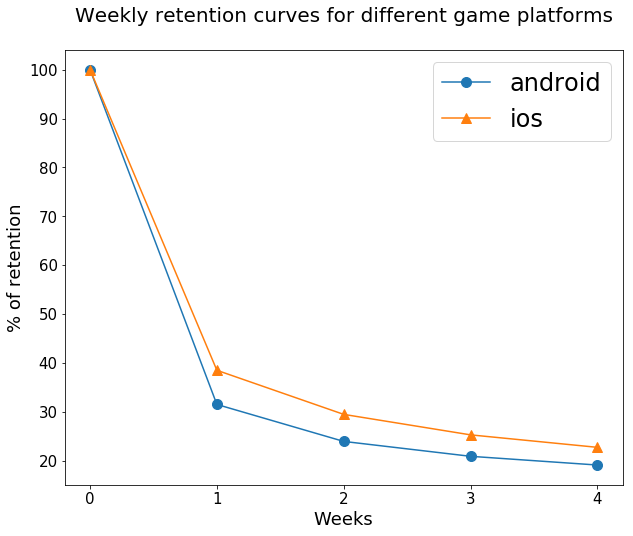

In [19]:
plt.figure(figsize=(10,8))

x = perc_ret.index
y1 = perc_ret.android
y2 = perc_ret.ios

plt.plot(x,y1,'o-',markersize=10)
plt.plot(x,y2,'^-',markersize=10)
plt.xticks(x,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Weeks',fontsize=18)
plt.ylabel('% of retention',fontsize=18)

plt.title('Weekly retention curves for different game platforms\n',fontsize=20)

plt.legend(fontsize=24)


#### ii. The five campaigns in terms of number of installs

In [20]:
df3.head()

,user_id,install_date,game_platform,country,campaign,activity_date
0,1111,2018-12-31,android,DE,29.0,2018-12-31
1,1111,2018-12-31,android,DE,29.0,2019-01-20
2,1119,2018-12-31,android,AT,29.0,2018-12-31
3,1119,2018-12-31,android,AT,29.0,2019-01-01
4,1119,2018-12-31,android,AT,29.0,2019-01-02


In [21]:
camps = df1.campaign.value_counts().to_frame()
camps.reset_index(inplace=True)
camps.rename(columns={'index':'campaign','campaign':'num_install'}, inplace=True)
camps.nlargest(5, 'num_install')
camps_best5 = camps[:5]
camps_best5

,campaign,num_install
0,25.0,284
1,29.0,192
2,2.0,180
3,3.0,166
4,26.0,115


In [22]:
df3_cbest5 = df3[df3['campaign'].isin(camps_best5.campaign.tolist())]

In [23]:
df3_cbest5.activity_date = pd.to_datetime(df3_cbest5.activity_date)
df3_cbest5.activity_date.dtypes
df3_cbest5.set_index((df3_cbest5.activity_date),inplace=True)

In [24]:
c25_byweek = df3_cbest5.loc[df3_cbest5['campaign'] == 25].user_id.resample('W').nunique()
c29_byweek = df3_cbest5.loc[df3_cbest5['campaign'] == 29].user_id.resample('W').nunique()
c2_byweek = df3_cbest5.loc[df3_cbest5['campaign'] == 2].user_id.resample('W').nunique()
c3_byweek = df3_cbest5.loc[df3_cbest5['campaign'] == 3].user_id.resample('W').nunique()
c26_byweek = df3_cbest5.loc[df3_cbest5['campaign'] == 26].user_id.resample('W').nunique()

In [25]:
def counter_c_users(cnum,camp_column):
    c_users = 0
    for i in camp_column:
        if i == cnum:
            c_users +=1
    return c_users

In [26]:
perc_ret_c25 = ((c25_byweek / counter_c_users(25,df1.campaign))*100).to_frame().reset_index().rename(columns={'user_id':'c25'})
perc_ret_c29 = ((c29_byweek / counter_c_users(29,df1.campaign))*100).to_frame().reset_index().rename(columns={'user_id':'c29'})
perc_ret_c2 = ((c2_byweek / counter_c_users(2,df1.campaign))*100).to_frame().reset_index().rename(columns={'user_id':'c2'})
perc_ret_c3 = ((c3_byweek / counter_c_users(3,df1.campaign))*100).to_frame().reset_index().rename(columns={'user_id':'c3'})
perc_ret_c26 = ((c26_byweek / counter_c_users(26,df1.campaign))*100).to_frame().reset_index().rename(columns={'user_id':'c26'})

In [27]:
df4 = pd.merge(perc_ret_c25,perc_ret_c29,on='activity_date')
df4 = pd.merge(df4,perc_ret_c2,on='activity_date')
df4 = pd.merge(df4,perc_ret_c3,on='activity_date')
df4 = pd.merge(df4,perc_ret_c26,on='activity_date')
df4

,activity_date,c25,c29,c2,c3,c26
0,2019-01-06,100.000000,100.000000,100.000000,100.000000,100.000000
1,2019-01-13,35.915493,36.979167,45.000000,43.975904,26.956522
2,2019-01-20,26.408451,28.645833,35.000000,31.325301,19.130435
3,2019-01-27,21.830986,26.562500,28.888889,27.108434,15.652174
4,2019-02-03,19.366197,28.125000,25.555556,24.698795,14.782609


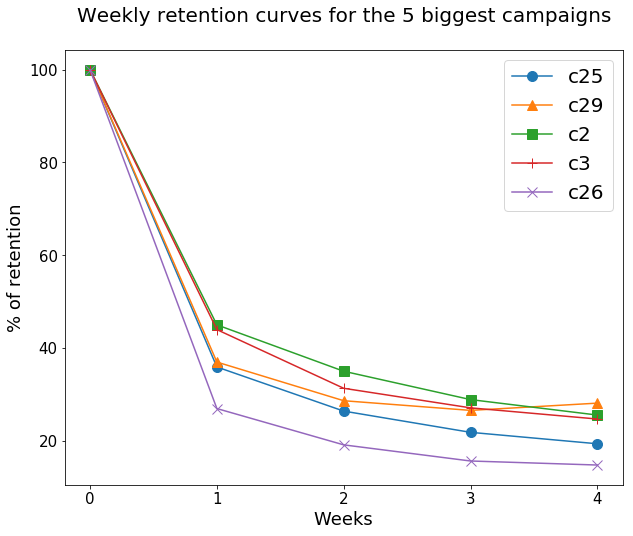

In [28]:
plt.figure(figsize=(10,8))
week_labels = range(0, 5)
x = df4.index
y1 = df4.c25
y2 = df4.c29
y3 = df4.c2
y4 = df4.c3
y5 = df4.c26

plt.plot(x,y1,'o-',markersize=10)
plt.plot(x,y2,'^-',markersize=10)
plt.plot(x,y3,'s-',markersize=10)
plt.plot(x,y4,'+-',markersize=10)
plt.plot(x,y5,'x-',markersize=10)

plt.xticks(week_labels,fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('Weeks',fontsize=18)
plt.ylabel('% of retention',fontsize=18)

plt.title('Weekly retention curves for the 5 biggest campaigns\n',fontsize=20)

plt.legend(fontsize=20)

## 1. Exploratory Analysis
### b. How are the retention curves evolving over time? Which cohort has the best retention at the end of the 5-week period?

In [29]:
perc_ret

,activity_date,android,ios
0,2019-01-06,100.000000,100.000000
1,2019-01-13,31.476616,38.468551
2,2019-01-20,23.909616,29.443938
3,2019-01-27,20.861797,25.250684
4,2019-02-03,19.075145,22.698268


In [30]:
week4ios = perc_ret.iloc[-1,2]
week4ios

22.69826800364631

In [31]:
week4android = perc_ret.iloc[-1,1]
week4android

19.07514450867052

In [32]:
week4campaigns = df4.iloc[-1,[1,2,3,4,5]]
week4campaigns

c25    19.3662
c29     28.125
c2     25.5556
c3     24.6988
c26    14.7826
Name: 4, dtype: object

The retention curves follow an exponential decay over time.
When the game is installed on ios platform we observe the best retention over 5 weeks of 23%, while the best performing campaign in terms of retention is the 29, with a 28% of retention.

## 2. Data Modeling
### a. Build a simple model to fit the weekly retention rate for the five biggest campaigns (Hint: Notice the shape of the retention curves. Consider adding non-linear components). Plot fitted versus real data values for the five campaigns.

In [33]:
indexes = perc_ret_c25.index.tolist()
x = []
for i in indexes:
    i = float(i)
    x.append(i)
x = np.asarray(x)
y1 = np.asarray(perc_ret_c25.c25)
y2 = np.asarray(perc_ret_c29.c29)
y3 = np.asarray(perc_ret_c2.c2)
y4 = np.asarray(perc_ret_c3.c3)
y5 = np.asarray(perc_ret_c26.c26)

In [34]:
def exponential_func(x, a, b, c):
    return a*np.exp(-b*x)+c

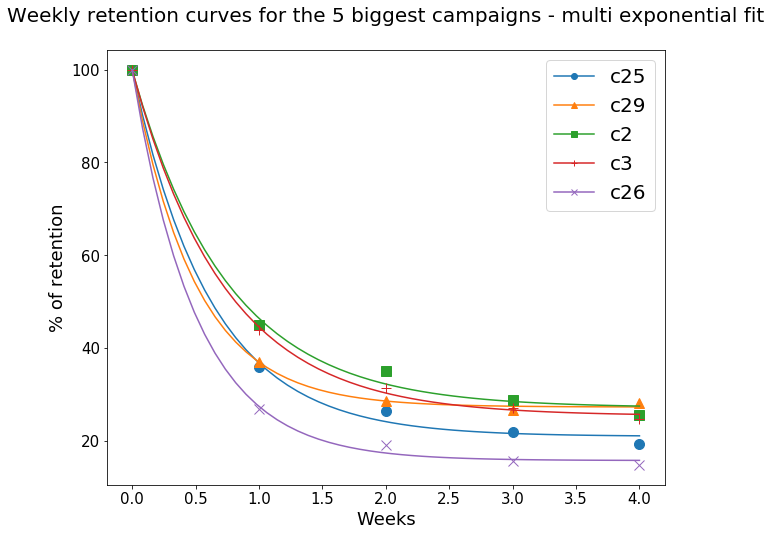

In [35]:
popt1, pcov1 = curve_fit(exponential_func, x, y1, p0=(1, 1e-6, 1))
popt2, pcov2 = curve_fit(exponential_func, x, y2, p0=(1, 1e-6, 1))
popt3, pcov3 = curve_fit(exponential_func, x, y3, p0=(1, 1e-6, 1))
popt4, pcov4 = curve_fit(exponential_func, x, y4, p0=(1, 1e-6, 1))
popt5, pcov5 = curve_fit(exponential_func, x, y5, p0=(1, 1e-6, 1))

xx = np.linspace(0, 4)
yy1 = exponential_func(xx, *popt1)
yy2 = exponential_func(xx, *popt2)
yy3 = exponential_func(xx, *popt3)
yy4 = exponential_func(xx, *popt4)
yy5 = exponential_func(xx, *popt5)

plt.figure(figsize=(10,8))
plot1 = plt.plot(x,y1,'o',xx, yy1,'#1f77b4',markersize=10)
plot2 = plt.plot(x,y2,'^',xx, yy2,'#ff7f0e',markersize=10)
plot3 = plt.plot(x,y3,'s',xx, yy3,'#2ca02c',markersize=10)
plot4 = plt.plot(x,y4,'+',xx, yy4,'#d62728',markersize=10)
plot5 = plt.plot(x,y5,'x',xx, yy5,'#9467bd',markersize=10)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('Weeks',fontsize=18)
plt.ylabel('% of retention',fontsize=18)

plt.title('Weekly retention curves for the 5 biggest campaigns - multi exponential fit\n',fontsize=20)

line1 = mlines.Line2D([], [], color='#1f77b4', marker='o',label='c25')
line2 = mlines.Line2D([], [], color='#ff7f0e', marker='^',label='c29')
line3 = mlines.Line2D([], [], color='#2ca02c', marker='s',label='c2')
line4 = mlines.Line2D([], [], color='#d62728', marker='+',label='c3')
line5 = mlines.Line2D([], [], color='#9467bd', marker='x',label='c26')
plt.legend(handles=[line1,line2,line3,line4,line5],fontsize=20)

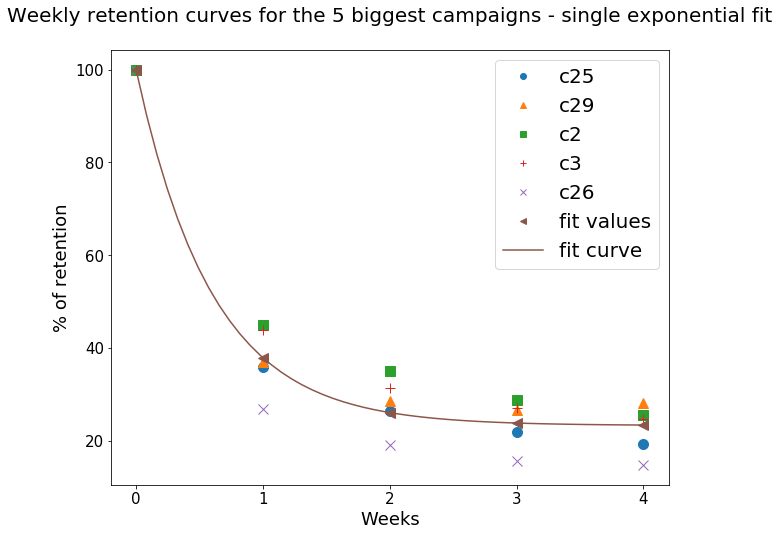

In [36]:
popt1, pcov1 = curve_fit(exponential_func, x, y1, p0=(1, 1e-6, 1))
popt2, pcov2 = curve_fit(exponential_func, x, y2, p0=(1, 1e-6, 1))
popt3, pcov3 = curve_fit(exponential_func, x, y3, p0=(1, 1e-6, 1))
popt4, pcov4 = curve_fit(exponential_func, x, y4, p0=(1, 1e-6, 1))
popt5, pcov5 = curve_fit(exponential_func, x, y5, p0=(1, 1e-6, 1))
popt1r = popt1.reshape(1,-1)
popt2r = popt2.reshape(1,-1)
popt3r = popt3.reshape(1,-1)
popt4r = popt4.reshape(1,-1)
popt5r = popt5.reshape(1,-1)

popt_tot = np.concatenate((popt1r, popt2r, popt3r, popt4r, popt5r))

popt_avg = np.mean(popt_tot, axis=0)

xx = np.linspace(0, 4)
yy = exponential_func(xx, *popt_avg)
xx_w = np.linspace(0, 4, 5)
yy_w = exponential_func(xx_w, *popt_avg)

plt.figure(figsize=(10,8))
plot1 = plt.plot(x,y1,'o',markersize=10)
plot2 = plt.plot(x,y2,'^',markersize=10)
plot3 = plt.plot(x,y3,'s',markersize=10)
plot4 = plt.plot(x,y4,'+',markersize=10)
plot5 = plt.plot(x,y5,'x',markersize=10)
plot6 = plt.plot(xx_w,yy_w,'<',markersize=10)
plot7 = plt.plot(xx,yy,'-',color='#8c564b')

plt.xticks(week_labels,fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel('Weeks',fontsize=18)
plt.ylabel('% of retention',fontsize=18)

plt.title('Weekly retention curves for the 5 biggest campaigns - single exponential fit\n',fontsize=20)

line1 = mlines.Line2D([], [], color='#1f77b4', marker='o', linestyle='',label='c25')
line2 = mlines.Line2D([], [], color='#ff7f0e', marker='^', linestyle='',label='c29')
line3 = mlines.Line2D([], [], color='#2ca02c', marker='s', linestyle='',label='c2')
line4 = mlines.Line2D([], [], color='#d62728', marker='+', linestyle='',label='c3')
line5 = mlines.Line2D([], [], color='#9467bd', marker='x', linestyle='',label='c26')
line6 = mlines.Line2D([], [], color='#8c564b', marker='<', linestyle='',label='fit values')
line7 = mlines.Line2D([], [], color='#8c564b', linestyle='-',label='fit curve')
plt.legend(handles=[line1,line2,line3,line4,line5,line6,line7],fontsize=20)

### b. How well do the model predictions fit the real data?

In [37]:
from sklearn.metrics import mean_squared_error

In [38]:
mse11 = mean_squared_error(y1, exponential_func(x, *popt1))
mse21 = mean_squared_error(y2, exponential_func(x, *popt2))
mse31 = mean_squared_error(y3, exponential_func(x, *popt3))
mse41 = mean_squared_error(y4, exponential_func(x, *popt4))
mse51 = mean_squared_error(y5, exponential_func(x, *popt5))
dict_mse1 = {'mse25':[mse11],'mse29':[mse21],'mse2':[mse31],'mse3':[mse41],'mse26':[mse51]}
mse_values1 = pd.DataFrame(data=dict_mse1)
mse_values1

,mse25,mse29,mse2,mse3,mse26
0,1.792791,0.294469,2.704103,0.518514,0.885115


In [39]:
mse12 = mean_squared_error(y1, yy_w)
mse22 = mean_squared_error(y2, yy_w)
mse32 = mean_squared_error(y3, yy_w)
mse42 = mean_squared_error(y4, yy_w)
mse52 = mean_squared_error(y5, yy_w)
dict_mse2 = {'mse25':[mse12],'mse29':[mse22],'mse2':[mse32],'mse3':[mse42],'mse26':[mse52]}
mse_values2 = pd.DataFrame(data=dict_mse2)
mse_values2

,mse25,mse29,mse2,mse3,mse26
0,4.879235,7.42825,31.987876,15.335104,61.918288


I used two different methods:
- method1: every data of each campaign is fitted to one model
- method2: all the data of the 5 campaigns are fitted to one curve

In method1 the best fit is for campaign 29, while in method2 the best fit is for campaign 25. 
Obviously the mean squared errors for the method1 are overall much lower. 

Having a model for each campaign is better (method1), but generally question arises if it is possible to do it (enough data of each campaign, number of campaign and consequent manageability of the data), as having only one model (method2) is easier to maintain.

## 3. Future Predictions
### a. Use your model to predict retention rates for the weeks 6 to 10 for each of the five campaigns.

<font color=red>Future predictions made with model built in **method1**: every data of each campaign is fitted to one model</font>

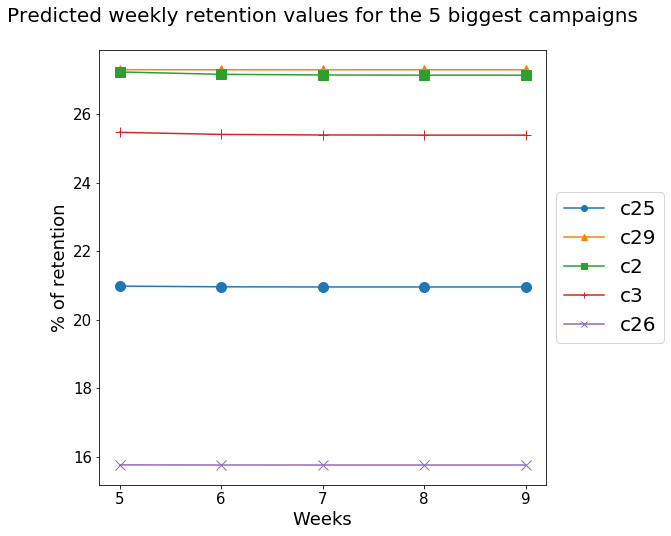

In [46]:
week_labels_future = range(5, 10)
xx = np.linspace(5, 9)

xx_w = np.linspace(5, 9, 5)

y_pred1 = exponential_func(xx_w, *popt1)
y_pred2 = exponential_func(xx_w, *popt2)
y_pred3 = exponential_func(xx_w, *popt3)
y_pred4 = exponential_func(xx_w, *popt4)
y_pred5 = exponential_func(xx_w, *popt5)

plt.figure(figsize=(10,8))
plot1 = plt.plot(xx_w,y_pred1,'o-',markersize=10)
plot2 = plt.plot(xx_w,y_pred2,'^-',markersize=10)
plot3 = plt.plot(xx_w,y_pred3,'s-',markersize=10)
plot4 = plt.plot(xx_w,y_pred4,'+-',markersize=10)
plot5 = plt.plot(xx_w,y_pred5,'x-',markersize=10)

plt.xticks(week_labels_future,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Weeks',fontsize=18)
plt.ylabel('% of retention',fontsize=18)

plt.title('Predicted weekly retention values for the 5 biggest campaigns\n',fontsize=20)

line1 = mlines.Line2D([], [], color='#1f77b4', marker='o', linestyle='-',label='c25')
line2 = mlines.Line2D([], [], color='#ff7f0e', marker='^', linestyle='-',label='c29')
line3 = mlines.Line2D([], [], color='#2ca02c', marker='s', linestyle='-',label='c2')
line4 = mlines.Line2D([], [], color='#d62728', marker='+', linestyle='-',label='c3')
line5 = mlines.Line2D([], [], color='#9467bd', marker='x', linestyle='-',label='c26')

ax = plt.subplot(111)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(handles=[line1,line2,line3,line4,line5],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20)

<font color=red>Future predictions made with model built in **method2**: all the data of the 5 campaigns are fitted to one curve</font>

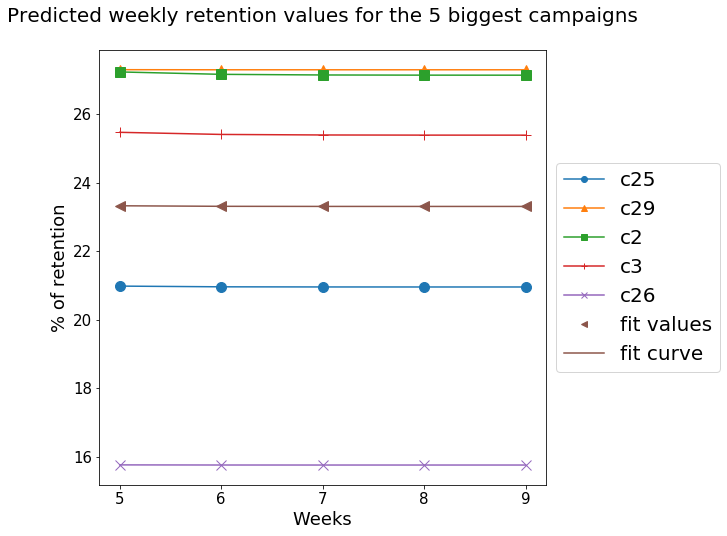

In [41]:
week_labels_future = range(5, 10)
xx = np.linspace(5, 9)
yy = exponential_func(xx, *popt_avg)

xx_w = np.linspace(5, 9, 5)
yy_w = exponential_func(xx_w, *popt_avg)

popt1fit, pcov1fit = curve_fit(exponential_func, x, y1, p0=popt_avg)
popt2fit, pcov2fit = curve_fit(exponential_func, x, y2, p0=popt_avg)
popt3fit, pcov3fit = curve_fit(exponential_func, x, y3, p0=popt_avg)
popt4fit, pcov4fit = curve_fit(exponential_func, x, y4, p0=popt_avg)
popt5fit, pcov5fit = curve_fit(exponential_func, x, y5, p0=popt_avg)

y_pred1 = exponential_func(xx_w, *popt1fit)
y_pred2 = exponential_func(xx_w, *popt2fit)
y_pred3 = exponential_func(xx_w, *popt3fit)
y_pred4 = exponential_func(xx_w, *popt4fit)
y_pred5 = exponential_func(xx_w, *popt5fit)

plt.figure(figsize=(10,8))
plot1 = plt.plot(xx_w,y_pred1,'o-',markersize=10)
plot2 = plt.plot(xx_w,y_pred2,'^-',markersize=10)
plot3 = plt.plot(xx_w,y_pred3,'s-',markersize=10)
plot4 = plt.plot(xx_w,y_pred4,'+-',markersize=10)
plot5 = plt.plot(xx_w,y_pred5,'x-',markersize=10)
plot6 = plt.plot(xx_w,yy_w,'<-',markersize=10)

plt.xticks(week_labels_future,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Weeks',fontsize=18)
plt.ylabel('% of retention',fontsize=18)

plt.title('Predicted weekly retention values for the 5 biggest campaigns\n',fontsize=20)

line1 = mlines.Line2D([], [], color='#1f77b4', marker='o', linestyle='-',label='c25')
line2 = mlines.Line2D([], [], color='#ff7f0e', marker='^', linestyle='-',label='c29')
line3 = mlines.Line2D([], [], color='#2ca02c', marker='s', linestyle='-',label='c2')
line4 = mlines.Line2D([], [], color='#d62728', marker='+', linestyle='-',label='c3')
line5 = mlines.Line2D([], [], color='#9467bd', marker='x', linestyle='-',label='c26')
#line6 = mlines.Line2D([], [], color='#8c564b', marker='<', linestyle='-',label='fit values')
line6 = mlines.Line2D([], [], color='#8c564b', marker='<', linestyle='',label='fit values')
line7 = mlines.Line2D([], [], color='#8c564b', linestyle='-',label='fit curve')

ax = plt.subplot(111)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax.legend(handles=[line1,line2,line3,line4,line5,line6,line7],loc='center left', bbox_to_anchor=(1, 0.5),fontsize=20)

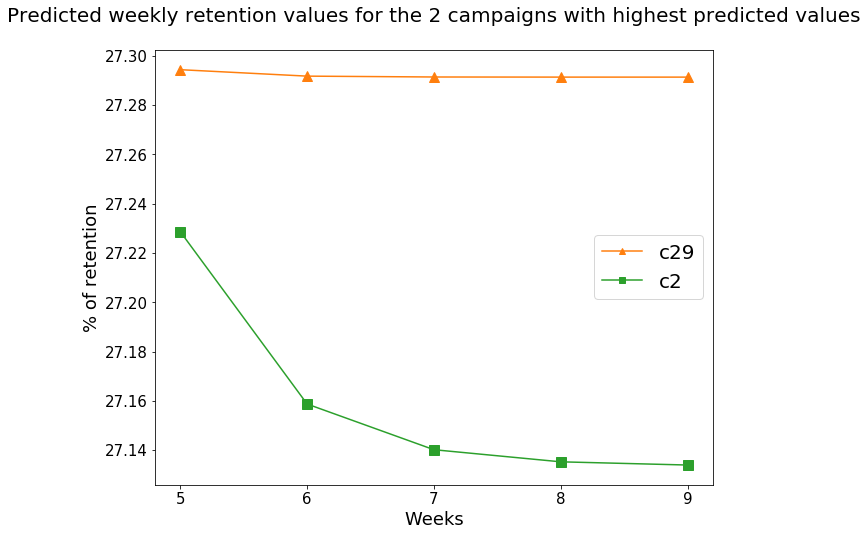

In [42]:
plt.figure(figsize=(10,8))
plot2 = plt.plot(xx_w,y_pred2,'^-',color='#ff7f0e',markersize=10)
plot3 = plt.plot(xx_w,y_pred3,'s-',color='#2ca02c',markersize=10)
plt.xticks(week_labels_future,fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Weeks',fontsize=18)
plt.ylabel('% of retention',fontsize=18)

plt.title('Predicted weekly retention values for the 2 campaigns with highest predicted values\n',fontsize=20)

#line1 = mlines.Line2D([], [], color='#1f77b4', marker='o', linestyle='-',label='c25')
line2 = mlines.Line2D([], [], color='#ff7f0e', marker='^', linestyle='-',label='c29')
line3 = mlines.Line2D([], [], color='#2ca02c', marker='s', linestyle='-',label='c2')
#line4 = mlines.Line2D([], [], color='#d62728', marker='+', linestyle='-',label='c3')
#line5 = mlines.Line2D([], [], color='#9467bd', marker='x', linestyle='-',label='c26')
#line6 = mlines.Line2D([], [], color='#8c564b', marker='<', linestyle='-',label='fit values')
plt.legend(handles=[line2,line3],loc='center right',fontsize=20)

In [43]:
dict_popts = {'c25':[popt1[1]],'c29':[popt2[1]],'c2':[popt3[1]],'c3':[popt4[1]],'c26':[popt5[1]]}
d_popts = pd.DataFrame(data=dict_popts)
d_popts

,c25,c29,c2,c3,c26
0,1.605812,2.01786,1.327647,1.359502,1.977393


In [44]:
dict_poptfits = {'c25':[popt1fit[1]],'c29':[popt2fit[1]],'c2':[popt3fit[1]],'c3':[popt4fit[1]],'c26':[popt5fit[1]]}
d_poptfits = pd.DataFrame(data=dict_poptfits)
d_poptfits

,c25,c29,c2,c3,c26
0,1.605815,2.017859,1.327646,1.359502,1.977393


In [45]:
camps_best5

,campaign,num_install
0,25.0,284
1,29.0,192
2,2.0,180
3,3.0,166
4,26.0,115


### b. Explain your results. What are your recommendations for the user acquisition team considering your findings? Do you see anything unsuspected?
The use of **method1** or **method2** in predicting the future values makes a very small difference (see the b parameters of the exponential functions).


Having a closer look at the campaign number 29 and comparing it, for example, with campaign number 2 is clear how the campaign number 29, which is the second best as number of installations, is the one that is predicted to retain better over time. The steepness of campaign 29, in fact, is 2.02 and is the highest over all the campaigns.